# Gradient descent implementations in SciPy Optimize.

## Needed Libraries import

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import OptimizeResult

## Helper functions for plots and output formatting


In [105]:
def plot(func, results_list, grid):
    if not isinstance(results_list, list):
        results_list = [results_list]

    x, y = np.meshgrid(np.linspace(grid[0], grid[1], 200), np.linspace(grid[0], grid[1], 200))

    z = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = func((x[i, j], y[i, j]))

    plt.figure()
    plt.contour(x, y, z, levels=30)

    for res in results_list:
        path = res.x_history
        plt.plot(path[:, 0], path[:, 1], label="GD path", marker='o')
        plt.plot(path[-1, 0], path[-1, 1], 'x', markersize=10)

    plt.xlim(grid)
    plt.ylim(grid)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()


def print_output(init, gd, func, grad, optimum, grid=(-6, 6)):
    res = gd(func, grad, init)
    error = np.linalg.norm(res.x - optimum)

    print(f"{'=' * 90}")
    print(f"Method: {gd.__name__}")
    print(f"Function: (x - 3)^2 + (y + 2)^2")
    print(f"Initial point: {init}")
    print(f"Real minimum: (3.0, -2.0)")
    print(f"{'=' * 90}")
    print(f"{'Method':<15} {'Found point':<20} {'f(x)':<10} {'Iterations':<15} {'Evals':<12} {'Error':<10}")
    print(f"{'-' * 90}")
    print(
        f"{'Stat':<15} ({res.x[0]:.3f}, {res.x[1]:.3f}) {" ":<5} {res.fun:<13.3f} {res.nit:<13} {res.nfev:<10} {error:<10.6f}")
    print(f"{'=' * 90}")

    plot(func, res, grid)

## Functions for research

### Symmetrical parabola

In [106]:
def func_sp(point):
    x, y = point
    return (x - 3) ** 2 + (y + 2) ** 2


def grad_sp(point):
    x, y = point
    return np.array([2 * (x - 3), 2 * (y + 2)])

### Rotated elliptical function

In [107]:
def func_re(point):
    x, y = point
    return (2 * (x + 2) ** 2) + (4 * x * y) + (3 * (y - 4) ** 2)


def grad_re(point):
    x, y = point
    return np.array([4 * (x + 2) + 4 * y, 4 * x + 6 * (y - 4)])

### Elliptical function with scale

In [108]:
def func_es(point):
    x, y = point
    return (8 * (x - 3) ** 2) + ((y + 1) ** 2)


def grad_es(point):
    x, y = point
    return np.array([16 * (x - 3), 2 * (y + 1)])

## Gradient Descent implementations with golden-section search

### Implementation of golden-section search

In [109]:
def golden_section_search(f, a, b, tol=1e-6, max_iter=1000):
    golden_ratio = (np.sqrt(5) - 1) / 2

    nfev = 0

    x1 = b - golden_ratio * (b - a)
    x2 = a + golden_ratio * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    nfev += 2

    nit = 0
    for nit in range(max_iter):
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + golden_ratio * (b - a)
            f2 = f(x2)
            nfev += 1
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - golden_ratio * (b - a)
            f1 = f(x1)
            nfev += 1

        if abs(b - a) < tol:
            break

    x_min = (a + b) / 2
    f_min = f(x_min)
    nfev += 1

    result = OptimizeResult(
        x=x_min,
        fun=f_min,
        nfev=nfev,
        nit=nit + 1,
        success=abs(b - a) < tol,
        status=0 if abs(b - a) < tol else 1,
    )

    return result

### Gradient descent based of previously implemented line search

In [110]:
def gd_gs(f, grad_f, x0, tol=1e-6, max_iter=10000):
    x = np.array(x0, dtype=float)

    nit = 0
    nfev = 1
    ngev = 0
    x_history = [x.copy()]

    for nit in range(max_iter):
        g = grad_f(x)
        ngev += 1

        if np.linalg.norm(g) < tol:
            break

        d = -g

        def f_along_line(alpha):
            return f(x + alpha * d)

        alpha_result = golden_section_search(f_along_line, 0, 1.0)
        alpha = alpha_result.x
        nfev += alpha_result.nfev

        x_new = x + alpha * d
        x_history.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            nfev += 1
            break

        x = x_new
        nfev += 1

    fun = f(x)

    result = OptimizeResult(
        x=x,
        fun=fun,
        jac=g,
        nfev=nfev,
        njev=ngev,
        nit=nit + 1,
        success=nit < max_iter - 1 or np.linalg.norm(g) < tol,
        x_history=np.array(x_history)
    )

    return result

## Results

### Symmetrical parabola: $(x - 3)^2 + (y + 2)^2$

Method: gd_gs
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 0]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -2.000)       0.000         3             67         0.000000  


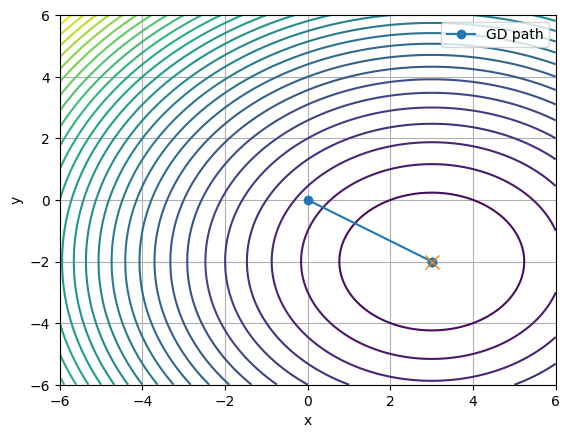

In [111]:
print_output([0, 0], gd_gs, func_sp, grad_sp, [3, -2])

### Rotated elliptical function: $2(x + 2)^2 + 4xy + 3(y - 4)^2$

Method: gd_gs
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 1]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-18.000, 16.000)       -208.000      38            1222       0.000001  


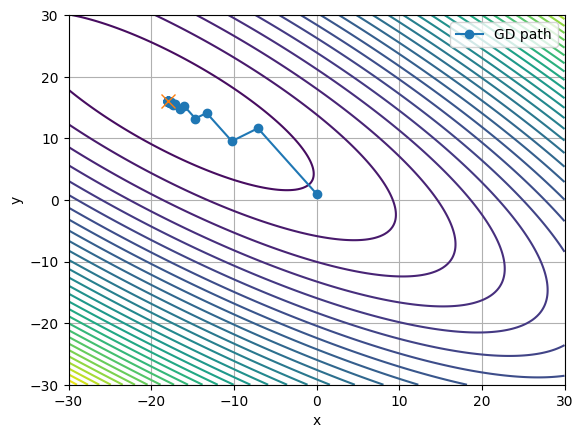

In [112]:
print_output([0, 1], gd_gs, func_re, grad_re, [-18, 16], [-30, 30])

### Elliptical function with scale: $8(x - 3)^2 + (y + 1)^2$

Method: gd_gs
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 2]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -1.000)       0.000         14            463        0.000000  


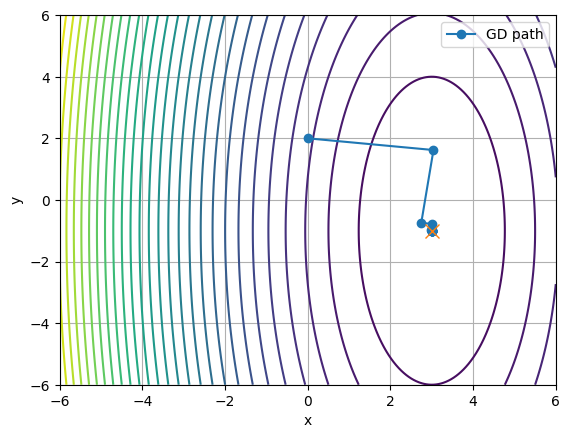

In [113]:
print_output([0, 2], gd_gs, func_es, grad_es, [3, -1])